This notebook uses ChemPlot, which is only compatible with Python 3.9 (or older)

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib_venn import venn3_unweighted as venn3

from parity import parity_plot
from umap_plotter import MoleculesUMAP

/home/jackson/miniconda3/envs/fastsolv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Had to manually open CombiSolvH-Exp and CombiSolv-Exp and export as CSV since they are malformed.

In [2]:
training_solutes = []
training_solvents = []
for training_set in (
    Path("../data/SolProp_v1.2/Data/AqueousSolu.csv"),
    Path("../data/SolProp_v1.2/Data/CombiSolv-Exp.csv"),
    Path("../data/SolProp_v1.2/Data/CombiSolv-QM.txt"),
    Path("../data/SolProp_v1.2/Data/CombiSolvH-Exp.csv"),
    Path("../data/SolProp_v1.2/Data/CombiSolvH-QM.txt"),
):
    if training_set.suffix == "xlsx":
        df = pd.read_excel(training_set)
    else:
        df = pd.read_csv(training_set)
    if "Aqueous" in training_set.name:
        training_solutes.extend(df["smiles solute"])
    elif "QM" in training_set.name:
        training_solutes.extend(df["smiles solute"])
        training_solvents.extend(df["smiles solvent"])
    else:
        training_solutes.extend(df["smiles_solute"])
        training_solvents.extend(df["smiles_solvent"])

# cast to set twice - once to remove immediate dupes, again to remove
# multiple identical representations
training_solvents = set(Chem.CanonSmiles(s) for s in set(training_solvents))
training_solutes = set(Chem.CanonSmiles(s) for s in set(training_solutes))
print(f"Training data includes {len(training_solvents):d} solvents and {len(training_solutes):d} solutes.")

[14:17:36] WARNING: not removing hydrogen atom without neighbors


Training data includes 1536 solvents and 20486 solutes.


In [3]:
df = pd.read_csv(Path("../data/vermeire/solprop_nonaq.csv"), index_col=0)
testing_solutes = set(Chem.CanonSmiles(s) for s in df["solute_smiles"])
testing_solvents = set(Chem.CanonSmiles(s) for s in df["solvent_smiles"])
print(f"Testing data includes {len(testing_solvents):d} solvents and {len(testing_solutes):d} solutes.")

Testing data includes 97 solvents and 99 solutes.


In [4]:
overlapping_solutes = testing_solutes.intersection(training_solutes)
overlapping_solvents = testing_solvents.intersection(training_solvents)
print(f"Overlap of train and test solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(testing_solutes):.2%} of test set.")
print(f"Overlap of train and test solvents is {len(overlapping_solvents):d}, or {len(overlapping_solvents)/len(testing_solvents):.2%} of test set.")

Overlap of train and test solutes is 76, or 76.77% of test set.
Overlap of train and test solvents is 95, or 97.94% of test set.


In [5]:
df = pd.read_csv(Path("../data/boobier/leeds_acetone.csv"), index_col=0)
leeds_acetone_solutes = set(Chem.CanonSmiles(s) for s in df["solute_smiles"])
print(f"Leeds acetone data includes {len(leeds_acetone_solutes):d} solutes.")
leeds_acetone_overlap = training_solutes.intersection(leeds_acetone_solutes)
print(
    f"Overlap of leeds acetone and train solutes is {len(leeds_acetone_overlap):d}, or {len(leeds_acetone_overlap)/len(leeds_acetone_solutes):.2%} of leeds acetone set."
)
df = pd.read_csv(Path("../data/boobier/leeds_benzene.csv"), index_col=0)
leeds_benzene_solutes = set(Chem.CanonSmiles(s) for s in df["solute_smiles"])
print(f"Leeds acetone data includes {len(leeds_benzene_solutes):d} solutes.")
leeds_benzene_overlap = training_solutes.intersection(leeds_benzene_solutes)
print(
    f"Overlap of leeds benzene and train solutes is {len(leeds_benzene_overlap):d}, or {len(leeds_benzene_overlap)/len(leeds_benzene_solutes):.2%} of leeds benzene set."
)
df = pd.read_csv(Path("../data/boobier/leeds_ethanol.csv"), index_col=0)
leeds_ethanol_solutes = set(Chem.CanonSmiles(s) for s in df["solute_smiles"])
print(f"Leeds acetone data includes {len(leeds_ethanol_solutes):d} solutes.")
leeds_ethanol_overlap = training_solutes.intersection(leeds_ethanol_solutes)
print(
    f"Overlap of leeds ethanol and train solutes is {len(leeds_ethanol_overlap):d}, or {len(leeds_ethanol_overlap)/len(leeds_ethanol_solutes):.2%} of leeds ethanol set."
)

Leeds acetone data includes 401 solutes.
Overlap of leeds acetone and train solutes is 162, or 40.40% of leeds acetone set.
Leeds acetone data includes 416 solutes.
Overlap of leeds benzene and train solutes is 181, or 43.51% of leeds benzene set.
Leeds acetone data includes 625 solutes.
Overlap of leeds ethanol and train solutes is 207, or 33.12% of leeds ethanol set.


[14:17:46] WARNING: not removing hydrogen atom without neighbors
/home/jackson/miniconda3/envs/fastsolv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<AxesSubplot:label='scatter', title={'center':'SolProp Training vs. Leeds Data'}, xlabel='UMAP-1', ylabel='UMAP-2'>

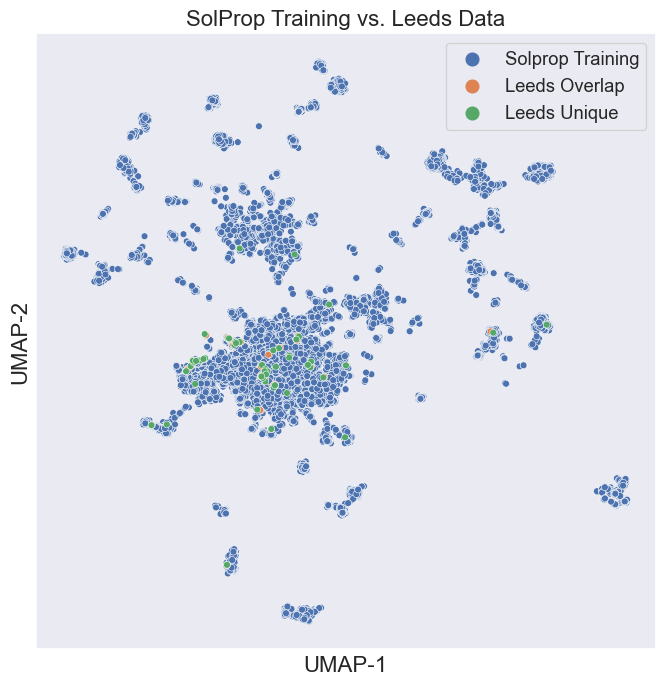

In [6]:
all_boobier_solutes = leeds_acetone_solutes.intersection(leeds_benzene_solutes).intersection(leeds_ethanol_solutes)
all_leeds_overlap = leeds_acetone_overlap.intersection(leeds_benzene_overlap).intersection(leeds_ethanol_overlap)
rng = np.random.default_rng(seed=2)
train_only_solutes = list(
    filter(lambda s: s not in all_leeds_overlap, training_solutes)
)  # rng.choice(list(filter(lambda s: s not in all_leeds_overlap, training_solutes)), 1_000, replace=False, shuffle=False)
combined_origin_list = (
    ["Solprop Training"] * len(train_only_solutes) + ["Leeds Overlap"] * len(all_leeds_overlap) + ["Leeds Unique"] * len(all_boobier_solutes)
)
combined_solute_list = list(train_only_solutes) + list(all_leeds_overlap) + list(all_boobier_solutes)
pltr = MoleculesUMAP.from_smiles(combined_solute_list, target=combined_origin_list, target_type="C", sim_type="structural")
pltr.umap(fit_on_target="Solprop Training", random_state=42)
pltr.visualize_plot(size=8, remove_outliers=False, title="SolProp Training vs. Leeds Data")

In [7]:
test_only_solutes = list(filter(lambda s: s not in overlapping_solutes, testing_solutes))
rng = np.random.default_rng(seed=2)
train_only_solutes = list(
    filter(lambda s: s not in overlapping_solutes, training_solutes)
)  # rng.choice(list(filter(lambda s: s not in overlapping_solutes, training_solutes)), 200, replace=False, shuffle=False)

In [8]:
combined_solute_list = list(train_only_solutes) + list(overlapping_solutes) + list(test_only_solutes)
combined_origin_list = ["Train Only"] * len(train_only_solutes) + ["Overlapping"] * len(overlapping_solutes) + ["Test Only"] * len(test_only_solutes)

In [9]:
pltr = MoleculesUMAP.from_smiles(combined_solute_list, target=combined_origin_list, target_type="C", sim_type="structural")

[14:19:54] WARNING: not removing hydrogen atom without neighbors


In [10]:
pltr.umap(fit_on_target="Train Only", random_state=42)

/home/jackson/miniconda3/envs/fastsolv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,UMAP-1,UMAP-2,target
0,8.730082,12.209289,Train Only
1,-8.156219,-6.890464,Train Only
2,2.790233,30.908205,Train Only
3,-7.688252,-7.539223,Train Only
4,13.951674,-5.330673,Train Only
...,...,...,...
20504,6.482334,13.712476,Test Only
20505,7.631229,10.602345,Test Only
20506,11.790557,19.671850,Test Only
20507,9.882412,22.641457,Test Only


<AxesSubplot:label='scatter', title={'center':'SolProp Training vs. Testing Data'}, xlabel='UMAP-1', ylabel='UMAP-2'>

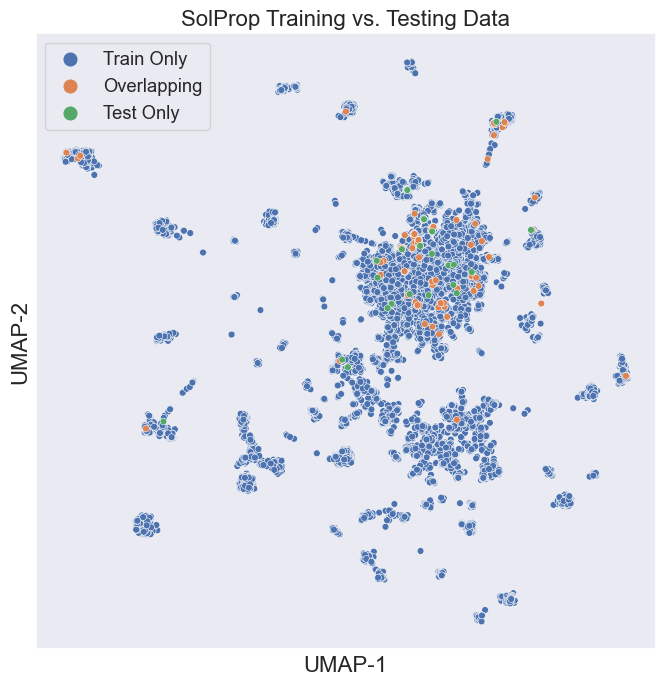

In [11]:
pltr.visualize_plot(size=8, remove_outliers=False, title="SolProp Training vs. Testing Data")

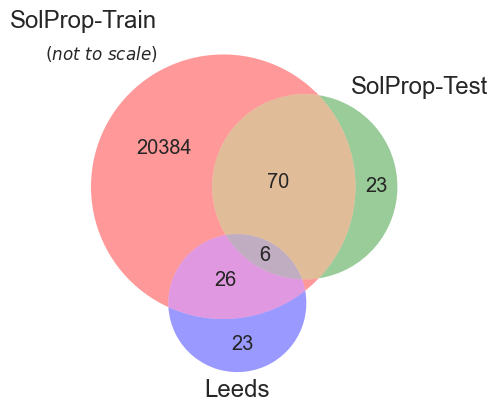

In [12]:
fig = venn3(
    [training_solutes, testing_solutes, all_boobier_solutes],
    ("SolProp-Train\n$_{\it{(not\ to\ scale)}}$", "SolProp-Test", "Leeds"),
    # first set, second set, overlap 1/2, 3rd, overlap 1/3, overlap 2/3, total overlap
    subset_areas=(100, 23, 70, 23, 26, 0, 6),
)
plt.show()